# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---
**TA** : Avinash, Samartha  <br>
**Release date**: 21/03/22  <br>
**Submission date** : 02/04/22 <br>

<center><b> Student Details </b></center>

**Name**: Avneesh Mishra <br>
**Roll No**: 2021701032 (M.S. - CSE) <br>
**EMail ID**: avneesh.mishra@research.iiit.ac.in <br>

---

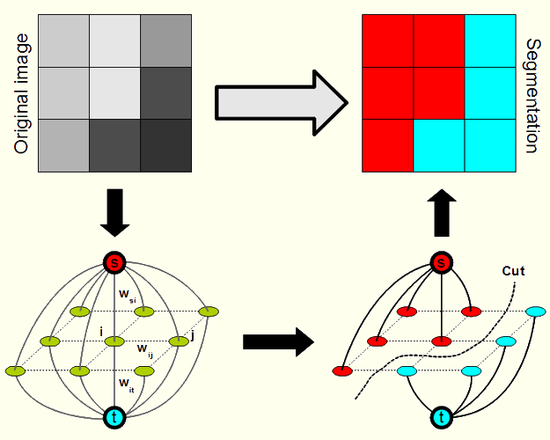

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below. 

<center>
<img src="./graphcut.png" alt="GraphCut image" width=300/>
</center>



The code given takes an input image and follows these steps:
- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation 
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
    - strokes on the background pixels
    - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.



**Useful Links**

- You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.
- https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf
- Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).


## Theory

Theoretical explanation of GrabCut


### Graph Cut

Prior explanation of the Graph Cut algorithm, upon which GrabCut is based.

**Paper**: `Boykov, Yuri Y., and M-P. Jolly. "Interactive graph cuts for optimal boundary & region segmentation of objects in ND images." Proceedings eighth IEEE international conference on computer vision. ICCV 2001. Vol. 1. IEEE, 2001.`


#### Image Segmentation Task

Image segmentation task (at least in this context) involves finding the background and foreground pixels in an image. It is assumed that there is a single subject and that the output is a binary classification (either the pixel is background or foreground). Graph cut performs image segmentation on **monochrome** images (grayscale).


#### Image parameters

The image is assumed as an array of $\mathbf{z} = (z_1, \dots , z_n, \dots, z_N)$ of grey values (the image has $N$ pixels - we flatten the image). 
The segmentation is expressed as an _opacity_ value vector $\underline{\alpha} = (\alpha_1, \dots, \alpha_N)$. 
For each pixel, $\alpha_n = 0$ if pixel is in _background, else if the pixel is in _foreground_ then $\alpha_n = 1$.

The parameters $\underline{\theta}$ describe the foreground and background grey-level distributions and consist of histogram grey values: $\underline{\theta} = \{ h(z; \alpha), \alpha = 0, 1 \}$. There will be two histograms (one for background and another for foreground). Histograms are normalized, this way they represent probability.

**Task**: Infer unknown $\underline{\alpha}$ from the image data $\mathbf{z}$ using model $\underline{\theta}$


#### Energy Minimization



An energy function whose minima corresponds to a good segmentation is shown below.

$$
\begin{equation*}
\mathbf{E} (\underline{\alpha}, \underline{\theta}, \mathbf{z}) = U(\underline{\alpha}, \underline{\theta}, \mathbf{z}) + V(\underline{\alpha}, \mathbf{z})
\end{equation*}
$$

Where
- $\mathbf{E}$ is the _Gibbs energy_
- $U$ evaluates the fit of the opacity distribution (how good $\underline{\alpha}$ is - 0 for good, $\infty$ for bad). This is given by

    $$
    U(\underline{\alpha}, \underline{\theta}, \mathbf{z}) = \sum_n - \log \left ( h(z_n; \alpha_n) \right )
    $$

    This will be high if there is high error in segmentation, and close to zero if error is low.

- $V$ is the _smoothness_ term (for coherence in regions of low contrast - similar grey-level values)

    $$
    V(\underline{\alpha}, \mathbf{z}) = \gamma \sum_{(m, n) \in \mathbf{C}} \left( d(m, n) \right)^{-1} \left[ \alpha_n \neq \alpha_m \right] \: \exp \left( -\beta (z_m - z_n)^2 \right)
    $$

    Where

    - $\left[ \phi \right] = 0$ if $\phi$ is `false`, else if $\phi$ is `true` then $\left[ \phi \right] = 1$: This is the indicator function.
    - $\mathbf{C}$ is the set of pairs of neighboring pixels. Usually we consider 4-neighbor or 8-neighbor arrangements.
    - $d(m,n)$ is the euclidean distance between the pixels $m$ and $n$
    - $\beta$ is a scaling constant, its best value was found to be

        $$ \beta = \left (2 \left \langle (z_m - z_n)^2 \right \rangle \right )^{-1} $$

        Where $\left \langle \cdot \right \rangle$ denotes the _expected_ value
    - $\gamma$ was best found to be $50$ by the authors of GrabCut. This is like a weight factor for this constraint.

    It is clear that this term is high if there is very low grey-level deviation between neighboring pixels belonging to different segmentation labels. We want similar colored, neighboring pixels to be in the same segment (this loosely holds true).


The segmentation can be estimated as a minimum of the Gibbs energy

$$
\underline{\hat{\alpha}}= \underset{\underline{\alpha}}{\textup{argmin}} \; \mathbf{E}(\underline{\alpha}, \underline{\theta})
$$


Minimization should be done using a standard minimum cut algorithm.

The authors use the min-cut max-flow algorithm. This algorithm is presented in the following paper

**Paper**: `Boykov, Yuri, and Vladimir Kolmogorov. "An experimental comparison of min-cut/max-flow algorithms for energy minimization in vision." IEEE transactions on pattern analysis and machine intelligence 26.9 (2004): 1124-1137.`


### GrabCut

Brief explanation of the GrabCut algorithm.

**Paper**: `Rother, Carsten, Vladimir Kolmogorov, and Andrew Blake. "" GrabCut" interactive foreground extraction using iterated graph cuts." ACM transactions on graphics (TOG) 23.3 (2004): 309-314.`


There are some changes that GrabCut proposes over the traditional Graph Cut algorithm

#### Color data modeling

Each pixel is now a point in RGB space (3D).
Instead of using histograms for modeling segmentations of grayscale images, GrabCut uses two *Gaussian Mixture Models* (one for background and one for foreground).

> **Gaussian Mixture Models** are probabilistic models that assume that the data is generated from a mixture of a finite number of Gaussian distributions. The mixture model can be through of as _k-means_ clustering and curve fitting. EM algorithms exist that yield these models in an iterative manner.

To keep track of the components of gaussian models (for the pixels), an additional vector $\mathbf{k} = \{ k_1, \dots k_n, \dots k_N \}$ is introduced, where $k_n \in \{1, \dots, K\}$ (where $K$ is the number of clusters/components; typically $K = 5$).


#### New Energy Formulation

Since this has now become a multi-dimensional model fitting problem, we make some changes to the Gibbs energy from Graph Cut (mentioned earlier).

$$
\mathbf{E} (\underline{\alpha}, \mathbf{k}, \underline{\theta}, \mathbf{z}) = U(\underline{\alpha}, \mathbf{k}, \underline{\theta}, \mathbf{z}) + V(\underline{\alpha}, \mathbf{z})
$$

Where the terms largely mean what they did earlier. Note that $\mathbf{k}$ is new and $\mathbf{z}$ is a vector of 3D numbers (pixels with RGB value).


The evaluation of the fit of the opacity distribution is now given by

$$
U(\underline{\alpha}, \mathbf{k}, \underline{\theta}, \mathbf{z}) = \sum_n D(\alpha_n, k_n, \underline{\theta}, z_n)
$$

Where $D$ is the opacity fit for the individual pixel given by

$$
\begin{align*}
    D(\alpha_n, k_n, \underline{\theta}, z_n) = &- \log \left ( \pi (\alpha_n, k_n) \right ) + \frac{1}{2} \log \| \Sigma (\alpha_n, k_n) \| \\
    &+ \frac{1}{2} \left[ z_n - \mu(\alpha_n, k_n) \right]^\top \left ( \Sigma(\alpha_n, k_n) \right )^{-1} \left [ z_n - \mu(\alpha_n, k_n) \right ]
\end{align*}
$$

Note how the last term is similar to the Mahalanobis distance (log of a Multivariate Gaussian Distribution). 


The contrast term (_smoothness_ term) is computed using Euclidean distance in color space of neighbors

$$
V(\alpha, \mathbf{z}) = \gamma \, \sum_{(m, n) \in \mathbf{C}} \left [ \alpha_n \neq \alpha_m \right ] \exp \left ( -\beta \| z_m - z_n \|^2 \right )
$$

Note that the $[\phi]$ is the indicator function ($1$ if $\phi$ is true, $0$ if false). Notice how this still means that similar pixels falling in different segmentation labels will yield a higher value.


The parameters are given by

$$
\underline{\theta} = \left \{ \pi(\alpha, k), \mu(\alpha, k), \Sigma(\alpha, k) \: ; \; 
\alpha = 0, 1 \:,\; k = 1, \dots, K \right \}
$$

For a given GMM component $k$ (for a particular $\alpha$ - foreground or background), the subset of pixels that adhere to this is given by $F(k) = \{ z_n: k_n = k \; \textup{and} \; \alpha_n = 1 \}$

The terms above are further described as
- The $\pi(\alpha, k)$ are the weights given by

    $$
    \pi(\alpha, k) = \frac{\left | F(k) \right |}{ \sum_k \left | F(k) \right |}
    $$

    Where $|\mathbf{S}|$ is the cardinality of the set $\mathbf{S}$ (number of elements in it).

- The $\mu(\alpha, k)$ and $\Sigma(\alpha, k)$ are the mean and covariance estimated through $F(k)$


#### Iterative Minimization

Finally, there is an optimization step as in Graph cut, to optimize for the best set of segmentation labels $\underline{\alpha}$. 

The basic flow of algorithm will be as follows


**Initialization**

- The user initializes the _trimap_ with $T_B$. The foreground is set to $T_F = \phi$ (null) and the undecided set is $T_U = \overline{T}_B$. This is usually by selecting pixels on the border of a rectangle or a lasso.

    > A **trimap** $T$ consists of background pixels $T_B$, foreground pixels $T_F$, and undecided/remaining region $T_U$; that is $T = \{ T_B, T_U, T_F \}$. We only need to segment (classify) the $T_U$ region as others are decided.

- We initialize $\alpha_n = 0$ for $n \in T_B$ (background) and $\alpha_n = 1$ for $n \in T_U$ (undecided).


**Iterative Minimization**

The following steps are done for a small number of iterations (convergence of Gibbs energy)

1. Assign GMM components to pixels: for each $n$ in $T_U$, we do $k_n := \underset{k_n}{\textup{argmin}} \; D_n(\alpha_n, k_n, \theta, z_n)$
2. Learn GMM parameters from data and current assignment. This is basically $\underline{\theta} := \underset{\underline{\theta}}{\textup{argmin}} \; U(\underline{\alpha}, \mathbf{k}, \underline{\theta}, \mathbf{z})$
3. Estimate the segmentation using min-cut (minimize Gibbs energy). This gives us the new segmentation map.

    $$ \underset{\{ \alpha_n : n \in T_U\}}{\textup{min}} \underset{\mathbf{k}}{\textup{min}} \: \mathbf{E}(\underline{\alpha}, \mathbf{k}, \underline{\theta}, \mathbf{z})$$

We repeat the above three steps until convergence. There is usually an additional step consisting of _border matting_ (where the boundary border pixels refined).


**User Edits**

Upon presenting the results, the user can fix some pixels either to $\alpha_n = 0$ (background) or $\alpha_n = 1$ (foreground). We update the trimap $T$ accordingly and either perform only step 3 above or run the entire iterative minimization.

## Practical Implementation

The practical implementation of the GrabCut algorithm


### Notes for Implementation

Some notes before implementing

- We use [scikit-learn]()
- The authors use a different segmentation algorithm (`min-cut max-flow`). We use the [igraph](https://igraph.org/) library to construct the graph. The library provides a straightforward st-mincut algorithm through a [function call](https://igraph.org/python/api/latest/igraph.Graph.html#st_mincut). `igraph` has other [flow algorithm](https://igraph.org/python/tutorial/latest/analysis.html#flow) implemented as well.

### Implementation code

Main code starts here


In [185]:
# ===== Import everything =====
# Core libraries
import numpy as np
import cv2
import igraph as ig
# Gaussian Mixture Models: https://scikit-learn.org/stable/modules/mixture.html#gmm
from sklearn.mixture import GaussianMixture
# Plotting
from matplotlib import pyplot as plt
# Utilities
import time
import traceback
import os
import glob

Configure the following parameters

In [2]:
NUM_GMM_K = 5   # For GMM
WEIGHT_GAMMA = 50   # For the contrast terms
SURE_EDGE = 10 * WEIGHT_GAMMA   # Connection length (for sure edge - bg or fg)
NUM_ITER = 3    # Number of iterations for running iterative minimization (grabcut theory)
MIN_CHANGE_ITER = 1e-3  # Minimum change in cost of maxflow/min-cut (for iterations)
FOUR_NEIGHBOR = 4
EIGHT_NEIGHBOR = 8

The main event handler for GUI and front-end

In [3]:
# Event handler (given code)
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, _state, colors):
        
        self.FLAGS = flags
        self.ix = -1    # From left vertical line
        self.iy = -1    # From top horizontal line
        self.img = img  # Everything will be drawn on this (in EventHandler)
        self.img2 = self.img.copy() # Backup of original (for restoring)
        self.COLORS = colors    # Drawing colors
        # Trimap: _mask + _state
        self._mask = _mask      # Alpha = 0 for BG (T_B), = 1 for FG (T_F)
        self._state = _state    # Decided (fixed) = 1, Undecided (unfixed) = 0 (T_U)

    # Proxy name ('image' same as 'img')
    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img

    # Proxy name ('mask' same as '_mask')
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    # Proxy name ('state' same as '_state')
    @property
    def state(self):
        return self._state
    
    @state.setter
    def state(self, _state):
        self._state = _state
    
    # Proxy name ('alpha' same as '_mask')
    @property
    def alpha(self):
        return self._mask
    
    @alpha.setter
    def alpha(self, _mask):
        self._mask = _mask
    
    # Proxy name ('flags' same as 'FLAGS')
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x,y  # Starting point (UL) of rectangle
        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['CYAN'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0
        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            # Finish the rectangle: (x, y, w, h)
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0
            # Initialize the alpha and state for trimap
            temp = np.zeros(self._state.shape, dtype=np.uint8)
            c, r, w, h = self.FLAGS['RECT']  # x, y, w = dx, h = dy: x from left, y from top
            temp[r:r+h, c:c+w] = 1
            self._state[temp == 0] = 1  # Fix outside rect (can't be optimized)
            self._mask[r:r+h, c:c+w] = 1    # Foreground inside the mask (undecided == can be optimized)
        
        # Draw strokes for refinement 
        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:    # Still in rectangle mode
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                # Alpha with the mode (0 for bg, 1 for fg), get 'val' for current stroke
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self._state, (x,y), 3, 1, -1)    # Fixed state (whatever it is)
        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                # Alpha with the mode (0 for bg, 1 for fg), get 'val' for current stroke
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self._state, (x,y), 3, 1, -1)    # Fixed state (whatever it is)
        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                # Alpha with the mode (0 for bg, 1 for fg), get 'val' for current stroke
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)
                cv2.circle(self._state, (x,y), 3, 1, -1)    # Fixed state (whatever it is)


The main running loop function `run` is declared below

In [4]:
def run(filename: str, num_gmm_k = NUM_GMM_K, gamma = WEIGHT_GAMMA, fix_edge = SURE_EDGE,
        num_iter = NUM_ITER, min_change_iter = MIN_CHANGE_ITER, nhood = EIGHT_NEIGHBOR, 
        verbose: bool = False):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {  # BGR values of common colors
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'CYAN'  : [255, 178, 25],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 0}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 1}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),  # x, y, dx, dy
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode (!not used!)
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground (current stroke)
    }

    # Input image
    img = cv2.imread(filename)
    img2 = img.copy()
    # mask = alpha value
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    # state = freeze or undecided
    state = np.zeros(img.shape[:2], dtype=np.uint8)  # state is a binary array with: 0 - unfixed (can be optimized)
                                                     #                               1 - fixed (cannot be optimized)
    # Output image to be shown
    output = np.zeros(img.shape, np.uint8)

    # Input and segmentation windows
    cv2.namedWindow('Input Image')      # Input image, with all annotations
    cv2.namedWindow('Segmented Image')  # Output (result)
    cv2.namedWindow('Alpha Mask')       # Background (0) or Foreground (1)
    cv2.namedWindow('State Mask')       # Fixed (1) or Undecided (0)
    # Some windows for debugging
    
    EventObj = EventHandler(FLAGS, img, mask, state, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)    # Move window on screen

    while(1):
        
        img = EventObj.image    # Current input image (with overlay)
        mask = EventObj.alpha       # alpha mask
        state = EventObj.state      # fixed (1) or not (0)
        FLAGS = EventObj.flags
        # Show windows
        cv2.imshow('Segmented Image', output)
        cv2.imshow('Input Image', img)
        cv2.imshow("Alpha Mask", mask*255)
        cv2.imshow("State Mask", state*255)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27 or k == ord('q'):
            print(f"Exit command received")
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG    # alpha = 0
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG    # alpha = 1
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8)
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == ord('s'):
            # save the mask
            cv2.imwrite("./mask_out.bmp", mask*255)
        
        elif k == 13: 
            # Press carriage return to initiate segmentation
            
            #-------------------------------------------------#
            # Implement GrabCut here.                         #  
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   # 
            #-------------------------------------------------#
            try:
                for new_alpha in grab_cut(img2, mask, state, gamma, num_gmm_k, fix_edge, 
                        num_iter, min_change_iter, nhood, verbose):
                    output1 = cv2.bitwise_and(img2, img2, mask=new_alpha.astype(np.uint8)*255)
                    cv2.imshow('Intermediate Image', output1)
                    cv2.waitKey(1)
                cv2.destroyWindow('Intermediate Image')
            except NameError as err:
                print(f"Check if function declated: {err}")
                raise err
            EventObj.alpha = new_alpha  # New segmentation result
            mask = new_alpha
            # Generate output from the new alpha
            EventObj.flags = FLAGS
            mask2 = np.where((mask == 1), 255, 0).astype('uint8')
            output = cv2.bitwise_and(img2, img2, mask = mask2)
    # Reply with result
    return mask

### Graph Cut function

Graph Cut is the backbone of GrabCut and is implemented below

In [5]:
def graph_cut(img: np.ndarray, alpha: np.ndarray, state: np.ndarray, 
        fg_gmm: GaussianMixture, bg_gmm: GaussianMixture, beta: float, 
        gamma: float, fix_edge: float, nhood: int, verbose: bool = False):
    # Compute region energy (proxy of D in Eq. 9 & 10) (H, W shape): -log
    D_fg = -fg_gmm.score_samples(img.reshape(-1, img.shape[-1])).reshape(img.shape[:-1])
    D_bg = -bg_gmm.score_samples(img.reshape(-1, img.shape[-1])).reshape(img.shape[:-1])
    # Compute V: Contrast term (Eq. 11)
    def compute_V(i1, j1, i2, j2):
        # if alpha[i1, j1] == alpha[i2, j2]:
        #     return 0
        # else:
        d = img[i1, j1] - img[i2, j2]
        e = gamma * np.exp(-beta*d.dot(d))
        return e
    # Build graph
    N = img.shape[0]*img.shape[1]   # Number of pixels
    # Get the vertex ID
    def vi(i, j):
        return (img.shape[1]*i + j)
    # Vertex ID to image
    def ic(i):
        return (i//img.shape[1]), (i%img.shape[1])
    # Build the graph for st-cut
    graph = ig.Graph(directed=False)
    graph.add_vertices(N+2) # All pixels + S + T
    S, T = N, N+1
    edges = []
    weights = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # If fixed, then add hard constraints
            if state[i, j] == 1:    # Fixed
                if alpha[i, j] == 1:    # Foreground
                    edges.append((vi(i, j), S))
                    weights.append(fix_edge)
                else:
                    edges.append((vi(i, j), T))
                    weights.append(fix_edge)
            else:   # state = 0: Not fixed (undecided)
                # Weight to foreground (source)
                edges.append((vi(i, j), S))
                weights.append(D_bg[i, j])
                # Weight to background (tank/sink)
                edges.append((vi(i, j), T))
                weights.append(D_fg[i, j])
                # Why swap fg & bg score here?
                #    If the p(fg) > p(bg), then -log(p(fg)) < -log(p(bg)).
                #    So that the maxflow selects 'fg', give it 'bg' value.
            # Add neighbors
            if i > 0:
                edges.append((vi(i, j), vi(i-1, j)))
                weights.append(compute_V(i, j, i-1, j))
            if j > 0:
                edges.append((vi(i, j), vi(i, j-1)))
                weights.append(compute_V(i, j, i, j-1))
            if nhood == 8:  # Diagonal neighbors
                if i > 0 and j > 0:
                    edges.append((vi(i, j), vi(i-1, j-1)))
                    weights.append(compute_V(i, j, i-1, j-1))
                if i > 0 and j < img.shape[1]-1:
                    edges.append((vi(i, j), vi(i-1, j+1)))
                    weights.append(compute_V(i, j, i-1, j+1))
    graph.add_edges(edges, attributes={'weight': weights})
    if verbose:
        print(f"[{time.time()}] Starting st_mincut")
    cut = graph.st_mincut(S, T, capacity='weight')
    bg_vs = cut.partition[0]
    fg_vs = cut.partition[1]
    if verbose:
        print(f"[{time.time()}] Finished st_mincut")
    if S in bg_vs:  # Partitions got swapped :')
        bg_vs, fg_vs = fg_vs, bg_vs
    # New mask from the graph cut (background and foreground)
    alpha_new = np.zeros_like(alpha, np.uint8)
    for v in fg_vs:
        if v not in [S, T]:
            alpha_new[ic(v)] = 1    # Foreground pixel
    return cut.value, alpha_new


### Gaussian Mixture Models

In [6]:
def fit_gmms(img, alphas, n_components):
    """
        Fits multiple GMM models to image, given alpha and number of components
    """
    fg = GaussianMixture(n_components=n_components)
    fg.fit(img[alphas == 1].reshape((-1, img.shape[-1])))
    bg = GaussianMixture(n_components=n_components)
    bg.fit(img[alphas == 0].reshape((-1, img.shape[-1])))
    return fg, bg

### GrabCut function

The GrabCut function

In [7]:
def grab_cut(img_: np.ndarray, alpha_: np.ndarray, state_: np.ndarray,
        gamma: float, gmm_kval: int, fix_edge: float, num_iter: int,
        min_change_iter: float, nhood: int, verbose: bool = False):
    """
        A function to handle the GrabCut algorithm.

        Parameters:
        - img_: np.ndarray  shape: H, W, 3      Input image
        - alpha_: np.ndarray     shape: H, W     Segmentation mask (0 for bg, 1 for fg)
        - state_: np.ndarray     shape: H, W     State of connections (0 for unfixed, 1 for fixed)
        - gamma: float      The weight of contrast / smoothness component (Gibbs energy)
        - gmm_kval: int     The 'k' value for GMM model
        - fix_edge: float   The connection of a fixed pixel to S (source/fg) or T (tank/bg)
        - num_iter: int     Number of iterations for minimization
        - min_change_iter   Minimum change in st-cut (energy) for next loop (else saturation)
        - nhood: int        Neighborhood (4 or 8)
        - verbose: bool     Print stats (default: False)
    """
    # Assertions
    assert nhood in [4, 8], "4 or 8 neighborhood ONLY"
    # Duplicate image
    img = img_.copy().astype(np.float32) # For operations
    alpha = alpha_.copy()
    state = state_.copy()
    # Calculate Beta (contrast term for gibbs) - Eq 5
    if verbose:
        print(f"[{time.time()}] Started GrabCut")
    beta = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if i > 0:
                d = img[i, j] - img[i-1, j]
                beta += d.dot(d)
            if j > 0:
                d = img[i, j] - img[i, j-1]
                beta += d.dot(d)
            if nhood == 8:  # Eight neighbor
                if i > 0 and j > 0:
                    d = img[i, j] - img[i-1, j-1]
                    beta += d.dot(d)
                if i > 0 and j < img.shape[1] - 1:
                    d = img[i, j] - img[i-1, j+1]
                    beta += d.dot(d)
    if nhood == 8:
        beta = beta/(4*img.shape[0]*img.shape[1] - 3*img.shape[0] - 3*img.shape[1] + 2)
    else:
        beta = beta/(2*img.shape[0]*img.shape[1] - img.shape[0] - img.shape[1])
    beta *= 2
    beta = 1/beta
    # print(f"[{time.time()}]: beta = {beta}")
    # Main iterative minimization
    prev_ener = None
    for i in range(num_iter):
        if verbose:
            print(f"[{time.time()}] Iteration {i} of GrabCut")
        # Fit GMMs for foreground and background images, using only alpha
        fg_gmm, bg_gmm = fit_gmms(img, alpha, gmm_kval)
        # Call the graph cut algorithm for optimizing 'alpha' (segmentation labels)
        cut_val, new_alpha = graph_cut(img, alpha, state, fg_gmm, bg_gmm, beta, gamma, fix_edge, 
            nhood, verbose)
        alpha = new_alpha
        if verbose:
            print(f"[{time.time()}] Iteration {i} gives: {cut_val}")
        # Return this new 'alpha' mask
        yield alpha
        # If the decrease in energy is appreciable
        if prev_ener is None:
            prev_ener = cut_val
        elif 0 < prev_ener - cut_val < min_change_iter:
            if verbose:
                print(f"Change in energy is very little (from {prev_ener} to {cut_val}).")
            break
        elif cut_val > prev_ener:   # min_change_iter is always > 0, but if -ve
            if verbose:
                print(f"WARN: The energy seems to have increased")
        prev_ener = cut_val
    if verbose:
        print(f"[{time.time()}] GrabCut finished")

In [9]:
if __name__ == '__main__':
    # An image file
    filename = '../images/banana1.jpg'
    try:
        rval = run(filename, 5, verbose=False)
    except Exception as exc:
        print(f"Exception: {exc}")
        traceback.print_exc()
    finally:
        cv2.destroyAllWindows()

Exit command received


In [ ]:
# Failsafe
cv2.destroyAllWindows()

Inspecting the output

In [11]:
# View everything
img = cv2.imread(filename)
im_mask = rval.copy()
img_gt_mask = cv2.imread(filename.replace("images/", "ground_truth/")\
    .replace(".jpg", ".bmp"), cv2.IMREAD_GRAYSCALE)

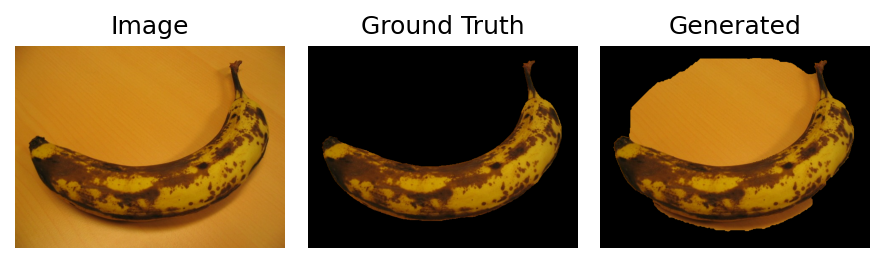

In [30]:
fig = plt.figure(figsize=(6, 15), dpi=150)
gs = fig.add_gridspec(1, 3)
# Main image
ax = fig.add_subplot(gs[0, 0])
ax.set_title("Image")
ax.imshow(img[..., ::-1])
ax.axis('off')
# Ground truth
img_gt_seg = cv2.bitwise_and(img, img, mask=img_gt_mask)
ax = fig.add_subplot(gs[0, 1])
ax.set_title("Ground Truth")
ax.imshow(img_gt_seg[..., ::-1])
ax.axis('off')
# Generated by algo
img_seg = cv2.bitwise_and(img, img, mask=im_mask)
ax = fig.add_subplot(gs[0, 2])
ax.set_title("Generated")
ax.imshow(img_seg[..., ::-1])
ax.axis('off')
fig.set_tight_layout(True)
plt.show(fig)

The above is with no user interaction after the segmentation output. The following is with user interaction (where the user adds foreground and background)


In [31]:
filename = '../images/banana1.jpg'
try:
    rval = run(filename, 5, verbose=False)
except Exception as exc:
    print(f"Exception: {exc}")
    traceback.print_exc()
finally:
    cv2.destroyAllWindows()

Exit command received


In [33]:
# Read everything
img = cv2.imread(filename)
im_mask = rval.copy()
img_gt_mask = cv2.imread(filename.replace("images/", "ground_truth/")\
    .replace(".jpg", ".bmp"), cv2.IMREAD_GRAYSCALE)

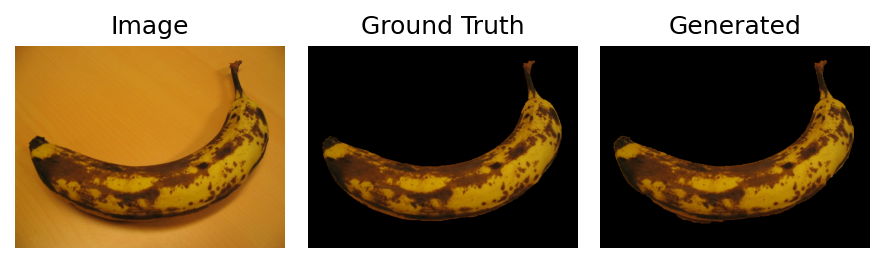

In [34]:
# View everything
fig = plt.figure(figsize=(6, 15), dpi=150)
gs = fig.add_gridspec(1, 3)
# Main image
ax = fig.add_subplot(gs[0, 0])
ax.set_title("Image")
ax.imshow(img[..., ::-1])
ax.axis('off')
# Ground truth
img_gt_seg = cv2.bitwise_and(img, img, mask=img_gt_mask)
ax = fig.add_subplot(gs[0, 1])
ax.set_title("Ground Truth")
ax.imshow(img_gt_seg[..., ::-1])
ax.axis('off')
# Generated by algo
img_seg = cv2.bitwise_and(img, img, mask=im_mask)
ax = fig.add_subplot(gs[0, 2])
ax.set_title("Generated")
ax.imshow(img_seg[..., ::-1])
ax.axis('off')
fig.set_tight_layout(True)
plt.show(fig)

The user interactions are shown below

<img src="./../out/user_acts/banana1.png" height=200 script="background-color:white" />

The rectangle (prior background) is in blue. For user interaction: the foreground is as white lines, background is as black lines.


## Deliverable 1: Evaluation Metrics

Accuracy, Jaccard Similarity and Dice similarity coefficient for all the images.

Outputs are stored in `out` folder. The `no_user` folder has segmentation bitmap (with no user interaction), the `user` has segmentation maps after additional user interaction, the `user_acts` folder shows the user actions (as described immediately above).

### Implementing metrics

Given a segmentation mask (generated using GrabCut) and the ground truth, report how good the segmentation result is

**Accuracy**: Number of correctly labelled (background or foreground labels) pixels divided by total number of pixels.

In [36]:
# Accuracy between bitmaps for segmentation: 1 - fg, 0 - bg
def metric_acc(img_mask: np.ndarray, img_gt_mask: np.ndarray):
    H, W = img_mask.shape
    num_pix = W*H
    incorr_label = cv2.bitwise_xor(img_mask, img_gt_mask)
    acc = 1 - (np.count_nonzero(incorr_label)/num_pix)
    return acc

**Jaccard Similarity**: Intersection over Union of predicted foreground and ground truth foreground.

In [37]:
# Jaccard similarity for foreground (predicted, ground truth)
def metric_jacc_sim(img_mask: np.ndarray, img_gt_mask: np.ndarray):
    intersect_img = cv2.bitwise_and(img_mask, img_gt_mask)
    union_img = cv2.bitwise_or(img_mask, img_gt_mask)
    jacc_sim = np.count_nonzero(intersect_img)/np.count_nonzero(union_img)
    return jacc_sim

**Dice similarity coefficient**: Twice the intersection divided by total pixels. We'll use this only for foreground images. This is also called the _F1-score_.

In [38]:
# Dice similarity
def metric_dice_sim(img_mask: np.ndarray, img_gt_mask: np.ndarray):
    nume = 2 * np.count_nonzero(cv2.bitwise_and(img_mask, img_gt_mask))
    deno = np.count_nonzero(img_mask) + np.count_nonzero(img_gt_mask)
    dice_f1 = nume/deno
    return dice_f1

### Main Results

The main results for all images, in a table (divided over many cells)

#### Generator Code

The snippet below is used to generate all results.

**Method**

The following method should be followed

1. Set the appropriate file name for image (to be segmented)
2. Run the code cell (keep `verbose=True` to get timestamps). If using `verbose`, then write the output in the `out/logs` folder (filename should match).
3. Select a rectangular region and press enter to run segmentation once (no brush interaction)
4. After getting the segmentation result, press `s` to save the mask. Move it in the `out/no_user` folder bearing the same file name.
5. Perform brush interaction to improve the segmentation even further. It's `0` to set as background and `1` to set the brush as foreground.
6. Press enter and get the new segmentation result.
7. Save this result too using `s` and move to `out/user` folder.
8. Save the user actions on the main image window using `Ctrl + S` (or take screenshot).

In [182]:
# Constants
filename = '../images/teddy.jpg'

In [183]:
# Main program loop
try:
    rval = run(filename, verbose=False)
except Exception as exc:
    print(f"Exception: {exc}")
    traceback.print_exc()
finally:
    cv2.destroyAllWindows()

Exit command received


In [174]:
# Read files
img = cv2.imread(filename)      # BGR Image
img_nou_mask = cv2.imread(filename.replace("images/", "out/no_user/")\
    .replace(".jpg", ".bmp"), cv2.IMREAD_GRAYSCALE)   # No user interaction
img_u_mask = cv2.imread(filename.replace("images/", "out/user/")\
    .replace(".jpg", ".bmp"), cv2.IMREAD_GRAYSCALE)   # With user interaction
img_action = cv2.imread(filename.replace("images/", "out/user_acts/")\
    .replace(".jpg", ".png"))   # User interaction (action on image)
img_gt_mask = cv2.imread(filename.replace("images/", "ground_truth/")\
    .replace(".jpg", ".bmp"), cv2.IMREAD_GRAYSCALE)   # Original ground truth

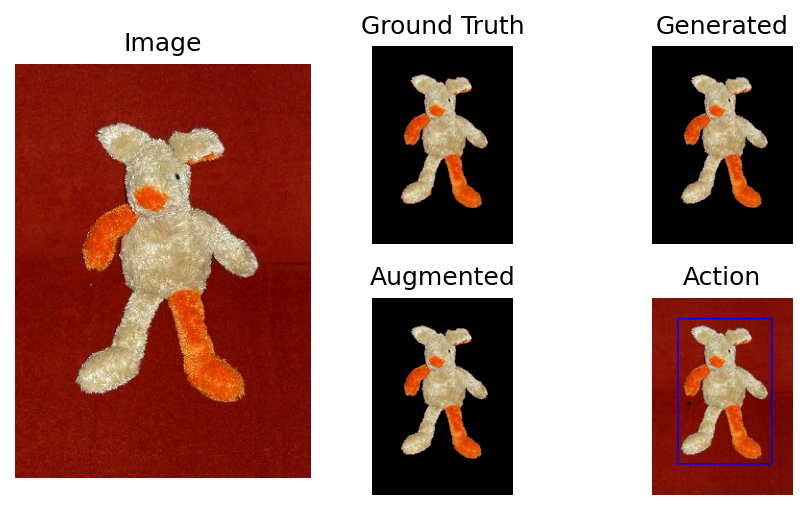

In [175]:
# Show the results
fig = plt.figure(figsize=(6, 3.5), dpi=150)
gs = fig.add_gridspec(2, 3)
# Main image
ax = fig.add_subplot(gs[:, 0])
ax.set_title("Image")
ax.imshow(img[..., ::-1])
ax.axis('off')
# Ground truth
img_gt_seg = cv2.bitwise_and(img, img, mask=img_gt_mask)
ax = fig.add_subplot(gs[0, 1])
ax.set_title("Ground Truth")
ax.imshow(img_gt_seg[..., ::-1])
ax.axis('off')
# Generated by algo
img_seg = cv2.bitwise_and(img, img, mask=img_nou_mask)
ax = fig.add_subplot(gs[0, 2])
ax.set_title("Generated")
ax.imshow(img_seg[..., ::-1])
ax.axis('off')
# Generated after user brush interactions
img_seg = cv2.bitwise_and(img, img, mask=img_u_mask)
ax = fig.add_subplot(gs[1, 1])
ax.set_title("Augmented")
ax.imshow(img_seg[..., ::-1])
ax.axis('off')
# User edits
ax = fig.add_subplot(gs[1, 2])
ax.set_title("Action")
ax.imshow(img_action[..., ::-1])
ax.axis('off')
# Final stuff
fig.set_tight_layout(True)
plt.show(fig)

In [184]:
# Metrics
print(f"Image: {filename}")
print(f"Accuracy:")
acc_nou = metric_acc(img_nou_mask, img_gt_mask)
acc_u = metric_acc(img_u_mask, img_gt_mask)
print(f"\tNOU: {acc_nou*100:.02f} %, U: {acc_u*100:.02f} %")
print(f"Jaccard similarity")
jac_nou = metric_jacc_sim(img_nou_mask, img_gt_mask)
jac_u = metric_jacc_sim(img_u_mask, img_gt_mask)
print(f"\tNOU: {jac_nou*100:.02f} %, U: {jac_u*100:.02f} %")
print(f"Dice similarity (F1)")
dice_nou = metric_dice_sim(img_nou_mask, img_gt_mask)
dice_u = metric_dice_sim(img_u_mask, img_gt_mask)
print(f"\tNOU: {dice_nou*100:.02f} %, U: {dice_u*100:.02f} %")

Image: ../images/teddy.jpg
Accuracy:
	NOU: 99.30 %, U: 99.25 %
Jaccard similarity
	NOU: 96.73 %, U: 96.51 %
Dice similarity (F1)
	NOU: 98.34 %, U: 98.22 %


The above can be done for each of the 30 images. This gives a complete dataset, which is summarized below

In [208]:
# Statistics (no user alteration)
min_acc = {"val": float('inf'), "img": None}    # Least accuracy
max_acc = {"val": -float('inf'), "img": None}   # Maximum accuracy
acc_avg = 0.0
min_jcs = {"val": float('inf'), "img": None}    # Least Jaccard Similarity
max_jcs = {"val": -float('inf'), "img": None}   # Maximum Jaccard Similarity
jcs_avg = 0.0
min_dcs = {"val": float('inf'), "img": None}    # Least Dice Similarity
max_dcs = {"val": -float('inf'), "img": None}   # Maximum Dice Similarity
dcs_avg = 0.0
# With user alteration
min_acc_u = {"val": float('inf'), "img": None}    # Least accuracy
max_acc_u = {"val": -float('inf'), "img": None}   # Maximum accuracy
acc_avg_u = 0.0
min_jcs_u = {"val": float('inf'), "img": None}    # Least Jaccard Similarity
max_jcs_u = {"val": -float('inf'), "img": None}   # Maximum Jaccard Similarity
jcs_avg_u = 0.0
min_dcs_u = {"val": float('inf'), "img": None}    # Least Dice Similarity
max_dcs_u = {"val": -float('inf'), "img": None}   # Maximum Dice Similarity
dcs_avg_u = 0.0
# Difference vectors
diff_acc = []
diff_jcs = []
diff_dcs = []
# For all images
imgs = [r.replace('\\', '/') for r in glob.glob("./../images/*.jpg")]
for filename in imgs:
    # Get data
    img_nou_mask = cv2.imread(filename.replace("images/", "out/no_user/")\
        .replace(".jpg", ".bmp"), cv2.IMREAD_GRAYSCALE)   # No user interaction
    img_u_mask = cv2.imread(filename.replace("images/", "out/user/")\
        .replace(".jpg", ".bmp"), cv2.IMREAD_GRAYSCALE)   # With user interaction
    img_gt_mask = cv2.imread(filename.replace("images/", "ground_truth/")\
        .replace(".jpg", ".bmp"), cv2.IMREAD_GRAYSCALE)   # Original ground truth
    # Accuracy
    acc_nou = metric_acc(img_nou_mask, img_gt_mask)
    if acc_nou > max_acc["val"]:
        max_acc["val"] = acc_nou
        max_acc["img"] = filename
    if acc_nou < min_acc["val"]:
        min_acc["val"] = acc_nou
        min_acc["img"] = filename
    acc_avg += acc_nou
    acc_u = metric_acc(img_u_mask, img_gt_mask)
    if acc_u > max_acc_u["val"]:
        max_acc_u["val"] = acc_u
        max_acc_u["img"] = filename
    if acc_u < min_acc_u["val"]:
        min_acc_u["val"] = acc_u
        min_acc_u["img"] = filename
    acc_avg_u += acc_u
    diff_acc.append(acc_u - acc_nou)
    # Jaccard Similarity (IoU)
    jac_nou = metric_jacc_sim(img_nou_mask, img_gt_mask)
    if jac_nou > max_jcs["val"]:
        max_jcs["val"] = jac_nou
        max_jcs["img"] = filename
    if jac_nou < min_jcs["val"]:
        min_jcs["val"] = jac_nou
        min_jcs["img"] = filename
    jcs_avg += jac_nou
    jac_u = metric_jacc_sim(img_u_mask, img_gt_mask)
    if jac_u > max_jcs_u["val"]:
        max_jcs_u["val"] = jac_u
        max_jcs_u["img"] = filename
    if jac_u < min_jcs_u["val"]:
        min_jcs_u["val"] = jac_u
        min_jcs_u["img"] = filename
    jcs_avg_u += jac_u
    diff_jcs.append(jac_u - jac_nou)
    # Dice Similarity (F1)
    dice_nou = metric_dice_sim(img_nou_mask, img_gt_mask)
    if dice_nou > max_dcs["val"]:
        max_dcs["val"] = dice_nou
        max_dcs["img"] = filename
    if dice_nou < min_dcs["val"]:
        min_dcs["val"] = dice_nou
        min_dcs["img"] = filename
    dcs_avg += dice_nou
    dice_u = metric_dice_sim(img_u_mask, img_gt_mask)
    if dice_u > max_dcs_u["val"]:
        max_dcs_u["val"] = dice_u
        max_dcs_u["img"] = filename
    if dice_u < min_dcs_u["val"]:
        min_dcs_u["val"] = dice_u
        min_dcs_u["img"] = filename
    dcs_avg_u += dice_u
    diff_dcs.append(dice_u - dice_nou)
# Average all this
N = len(imgs)
acc_avg /= N
acc_avg_u /= N
jcs_avg /= N
jcs_avg_u /= N
dcs_avg /= N
dcs_avg_u /= N
# Difference to numpy
diff_acc = np.array(diff_acc)
diff_jcs = np.array(diff_jcs)
diff_dcs = np.array(diff_dcs)

In [209]:
print(f"Averages:")
print(f"\tAccuracy: No user = {acc_avg*100:.1f} %, User = {acc_avg_u*100:.2f} %")
print(f"\tJaccard Similarity: No user = {jcs_avg*100:.1f} %, User = {jcs_avg_u*100:.2f} %")
print(f"\tDice Similarity: No user = {dcs_avg*100:.1f} %, User = {dcs_avg_u*100:.2f} %")

Averages:
	Accuracy: No user = 93.6 %, User = 99.20 %
	Jaccard Similarity: No user = 81.7 %, User = 95.55 %
	Dice Similarity: No user = 88.4 %, User = 97.71 %


In [210]:
print(f"No user interaction stats\n"
      f"\tAccuracy\n"
      f"\t\tMin = {min_acc['val']*100:.2f}, img = {min_acc['img']}\n"
      f"\t\tMax = {max_acc['val']*100:.2f}, img = {max_acc['img']}\n"
      f"\tJaccard Similarity\n"
      f"\t\tMin = {min_jcs['val']*100:.2f}, img = {min_jcs['img']}\n"
      f"\t\tMax = {max_jcs['val']*100:.2f}, img = {max_jcs['img']}\n"
      f"\tDice Similarity\n"
      f"\t\tMin = {min_dcs['val']*100:.2f}, img = {min_dcs['img']}\n"
      f"\t\tMax = {max_dcs['val']*100:.2f}, img = {max_dcs['img']}\n"
)

No user interaction stats
	Accuracy
		Min = 43.12, img = ./../images/cross.jpg
		Max = 99.65, img = ./../images/flower.jpg
	Jaccard Similarity
		Min = 26.80, img = ./../images/cross.jpg
		Max = 98.45, img = ./../images/stone2.jpg
	Dice Similarity
		Min = 42.28, img = ./../images/cross.jpg
		Max = 99.22, img = ./../images/stone2.jpg



In [211]:
print(f"User interaction stats\n"
      f"\tAccuracy\n"
      f"\t\tMin = {min_acc_u['val']*100:.2f}, img = {min_acc_u['img']}\n"
      f"\t\tMax = {max_acc_u['val']*100:.2f}, img = {max_acc_u['img']}\n"
      f"\tJaccard Similarity\n"
      f"\t\tMin = {min_jcs_u['val']*100:.2f}, img = {min_jcs_u['img']}\n"
      f"\t\tMax = {max_jcs_u['val']*100:.2f}, img = {max_jcs_u['img']}\n"
      f"\tDice Similarity\n"
      f"\t\tMin = {min_dcs_u['val']*100:.2f}, img = {min_dcs_u['img']}\n"
      f"\t\tMax = {max_dcs_u['val']*100:.2f}, img = {max_dcs_u['img']}\n"
)

User interaction stats
	Accuracy
		Min = 97.70, img = ./../images/book.jpg
		Max = 99.78, img = ./../images/stone1.jpg
	Jaccard Similarity
		Min = 86.37, img = ./../images/scissors.jpg
		Max = 98.83, img = ./../images/stone1.jpg
	Dice Similarity
		Min = 92.68, img = ./../images/scissors.jpg
		Max = 99.41, img = ./../images/stone1.jpg



In [214]:
print(f"Effect (benefit) of user labelling\n"
    f"\tAccuracy\n"
    f"\t\tMin: {np.min(diff_acc)*100:.2f}, img: {imgs[np.argmin(diff_acc)]}\n"
    f"\t\tMax: {np.max(diff_acc)*100:.2f}, img: {imgs[np.argmax(diff_acc)]}\n"
    f"\tJaccard Similarity\n"
    f"\t\tMin: {np.min(diff_jcs)*100:.2f}, img: {imgs[np.argmin(diff_jcs)]}\n"
    f"\t\tMax: {np.max(diff_jcs)*100:.2f}, img: {imgs[np.argmax(diff_jcs)]}\n"
    f"\tDice Similarity\n"
    f"\t\tMin: {np.min(diff_dcs)*100:.2f}, img: {imgs[np.argmin(diff_dcs)]}\n"
    f"\t\tMax: {np.max(diff_dcs)*100:.2f}, img: {imgs[np.argmax(diff_dcs)]}\n"
)

Effect (benefit) of user labelling
	Accuracy
		Min: -0.05, img: ./../images/teddy.jpg
		Max: 54.93, img: ./../images/cross.jpg
	Jaccard Similarity
		Min: -0.22, img: ./../images/teddy.jpg
		Max: 68.04, img: ./../images/cross.jpg
	Dice Similarity
		Min: -0.11, img: ./../images/teddy.jpg
		Max: 55.08, img: ./../images/cross.jpg



From the above, we can see that the `teddy` was not affected much by user labelling, but `cross` was. Let's visualize `cross` below.

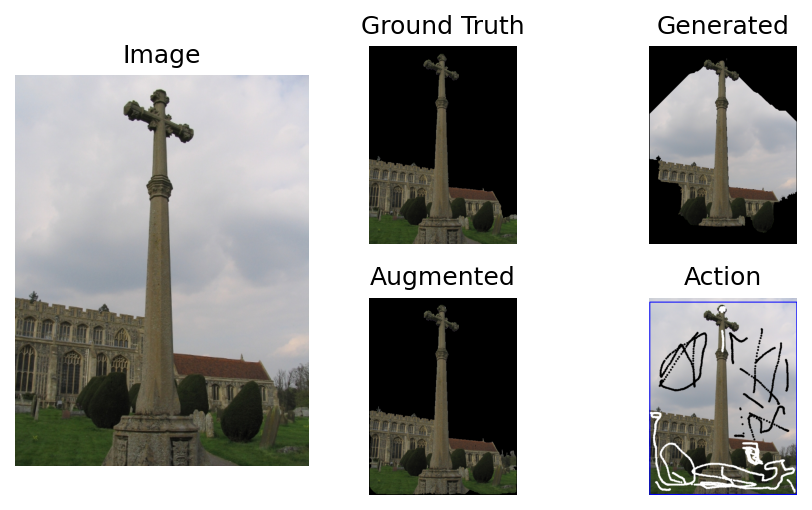

In [216]:
def show_everything_seg(filename: str):
    # Read files
    img = cv2.imread(filename)      # BGR Image
    img_nou_mask = cv2.imread(filename.replace("images/", "out/no_user/")\
        .replace(".jpg", ".bmp"), cv2.IMREAD_GRAYSCALE)   # No user interaction
    img_u_mask = cv2.imread(filename.replace("images/", "out/user/")\
        .replace(".jpg", ".bmp"), cv2.IMREAD_GRAYSCALE)   # With user interaction
    img_action = cv2.imread(filename.replace("images/", "out/user_acts/")\
        .replace(".jpg", ".png"))   # User interaction (action on image)
    img_gt_mask = cv2.imread(filename.replace("images/", "ground_truth/")\
        .replace(".jpg", ".bmp"), cv2.IMREAD_GRAYSCALE)   # Original ground truth
    # Visualize things
    fig = plt.figure(figsize=(6, 3.5), dpi=150)
    gs = fig.add_gridspec(2, 3)
    # Main image
    ax = fig.add_subplot(gs[:, 0])
    ax.set_title("Image")
    ax.imshow(img[..., ::-1])
    ax.axis('off')
    # Ground truth
    img_gt_seg = cv2.bitwise_and(img, img, mask=img_gt_mask)
    ax = fig.add_subplot(gs[0, 1])
    ax.set_title("Ground Truth")
    ax.imshow(img_gt_seg[..., ::-1])
    ax.axis('off')
    # Generated by algo
    img_seg = cv2.bitwise_and(img, img, mask=img_nou_mask)
    ax = fig.add_subplot(gs[0, 2])
    ax.set_title("Generated")
    ax.imshow(img_seg[..., ::-1])
    ax.axis('off')
    # Generated after user brush interactions
    img_seg = cv2.bitwise_and(img, img, mask=img_u_mask)
    ax = fig.add_subplot(gs[1, 1])
    ax.set_title("Augmented")
    ax.imshow(img_seg[..., ::-1])
    ax.axis('off')
    # User edits
    ax = fig.add_subplot(gs[1, 2])
    ax.set_title("Action")
    ax.imshow(img_action[..., ::-1])
    ax.axis('off')
    # Final stuff
    fig.set_tight_layout(True)
    return fig

fig = show_everything_seg("../images/cross.jpg")
plt.show(fig)

This (`cross`) had high action (lowest accuracy without user interaction). Let's see other two interesting images on which our "user segmentation" yields the _most_ poor final results

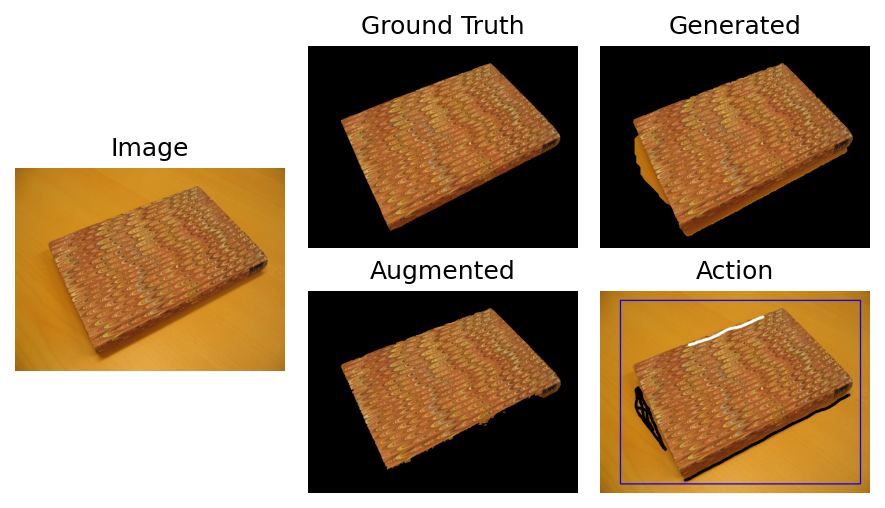

In [218]:
fig = show_everything_seg("../images/book.jpg")
plt.show(fig)

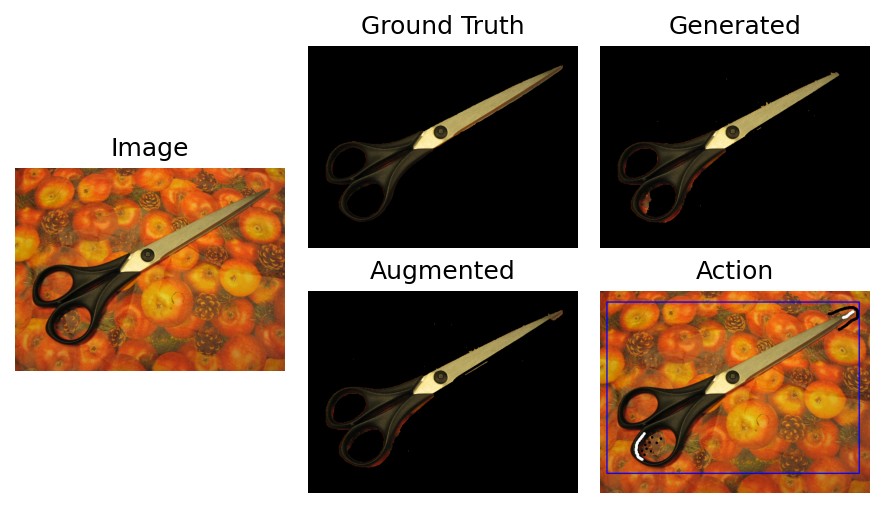

In [219]:
fig = show_everything_seg("../images/scissors.jpg")
plt.show()

The above two look good. Let's see some person images.

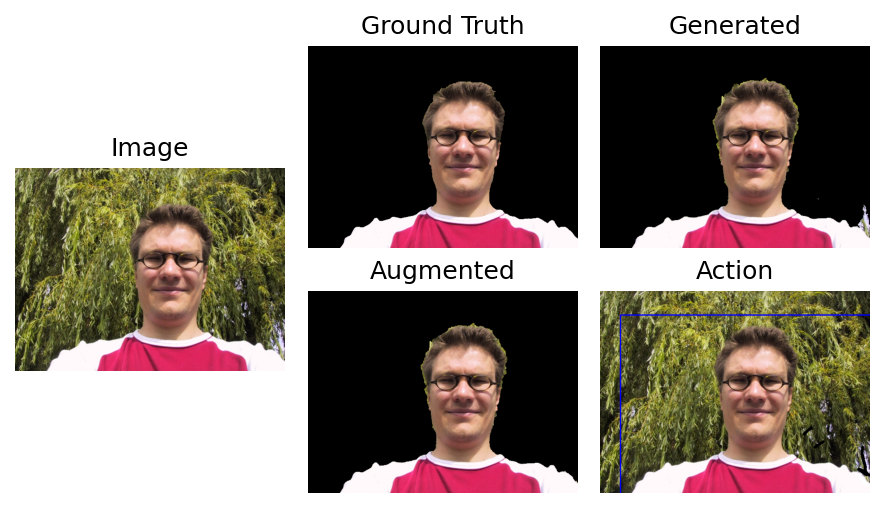

In [220]:
fig = show_everything_seg("../images/person1.jpg")
plt.show()

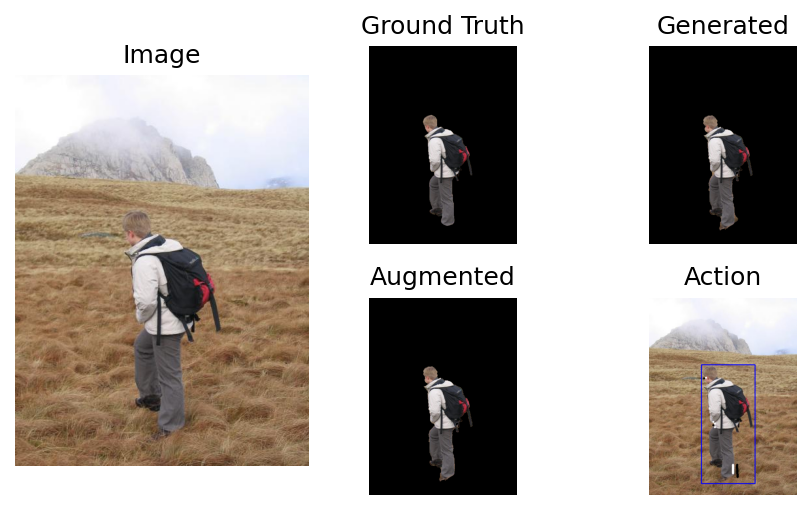

In [221]:
fig = show_everything_seg("../images/person3.jpg")
plt.show()

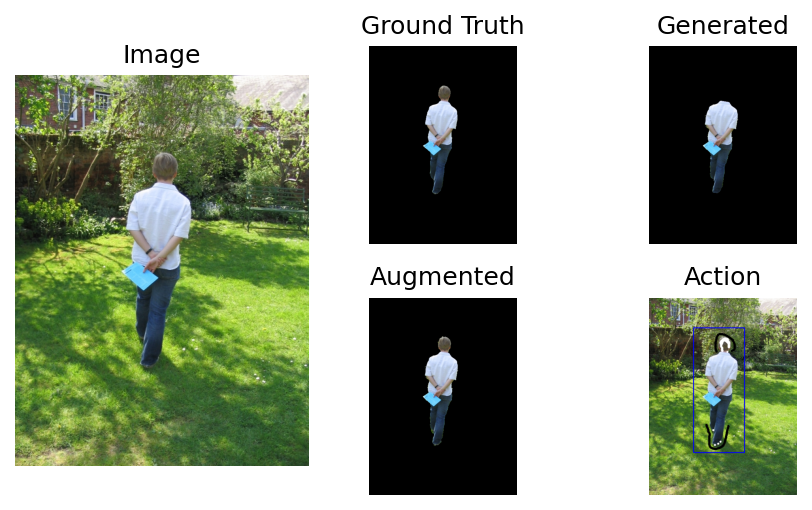

In [222]:
fig = show_everything_seg("../images/person7.jpg")
plt.show()

**Time taken**

- `cross` took 272 seconds for the default parameters
- `book` took 308 seconds for the default parameters
- `scissors` took only 64 seconds (might be the sparse graph connectivity which accelerates st-mincut)
- `person1` took 42 seconds
- `person3` took 35 seconds
- `person7` took 48 seconds

All these are using default parameters (check `out/logs`).

In [224]:
# Some space for rough work!

## Deliverable 2: Report

### Number of iterations for GMM update & energy minimization

As we increase number of iterations, the energy minimization algorithm discovers and removes points from $T_U$ into $T_B$ (effectively leaving $T_U$ with predicted foreground). One can say that increasing this value should give to better segmentation results. However, we have seen in some output logs (see `out/logs` files) where the energy stagnates and applying this further is just useless.

Let's see this in action for `person1` (we'll not apply any user refinement in the end, just for a level ground)

In [225]:
# -------- 1 iteration --------
filename = '../images/person1.jpg'
# Main program loop
try:
    rval = run(filename, num_iter = 1, verbose=True)
except Exception as exc:
    print(f"Exception: {exc}")
    traceback.print_exc()
finally:
    cv2.destroyAllWindows()

[1648920591.7972493] Started GrabCut
[1648920593.474251] Iteration 0 of GrabCut
[1648920607.2667782] Starting st_mincut
[1648920609.8267787] Finished st_mincut
[1648920610.0147789] Iteration 0 gives: 2608639.108452374
[1648920610.0917795] GrabCut finished
Exit command received


In [226]:
# -------- 3 iterations --------
filename = '../images/person1.jpg'
# Main program loop
try:
    rval = run(filename, num_iter = 3, verbose=True)
except Exception as exc:
    print(f"Exception: {exc}")
    traceback.print_exc()
finally:
    cv2.destroyAllWindows()

[1648920718.5460038] Started GrabCut
[1648920720.229] Iteration 0 of GrabCut
[1648920732.7830102] Starting st_mincut
[1648920735.5380037] Finished st_mincut
[1648920735.7680085] Iteration 0 gives: 2757529.717892267
[1648920735.7960029] Iteration 1 of GrabCut
[1648920747.5590043] Starting st_mincut
[1648920749.184] Finished st_mincut
[1648920749.355037] Iteration 1 gives: 2641191.2777938624
[1648920749.368001] Iteration 2 of GrabCut
[1648920760.7190104] Starting st_mincut
[1648920762.2820008] Finished st_mincut
[1648920762.446004] Iteration 2 gives: 2635168.583161658
[1648920762.4550047] GrabCut finished
Exit command received


(-0.5, 599.5, 449.5, -0.5)

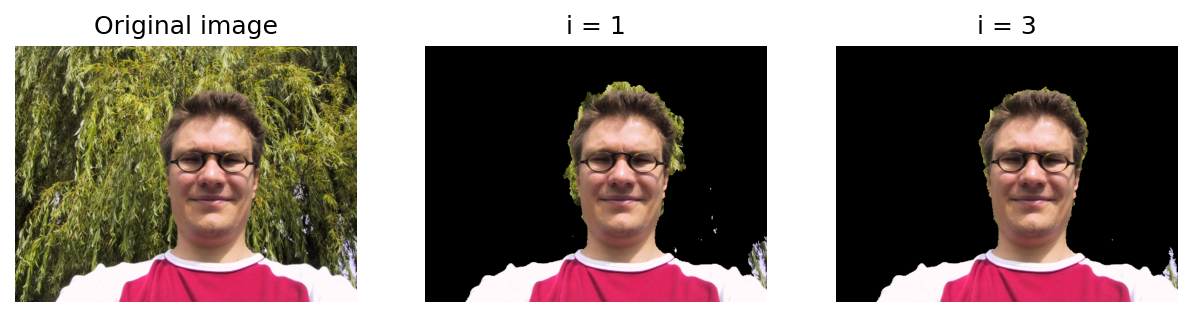

In [237]:
# Comparing the results
img = cv2.imread(filename)
mask1 = cv2.imread("./../study/iters/mask_i1.bmp", cv2.IMREAD_GRAYSCALE)
mask2 = cv2.imread("./../study/iters/mask_i3.bmp", cv2.IMREAD_GRAYSCALE)
# Visualize things
plt.figure(figsize=(10, 5.5), dpi=150)
plt.subplot(1,3,1)
plt.title("Original image")
plt.imshow(img[..., ::-1])
plt.axis('off')
plt.subplot(1,3,2)
plt.title("i = 1")
img_i1 = cv2.bitwise_and(img, img, mask=mask1)
plt.imshow(img_i1[..., ::-1])
plt.axis('off')
plt.subplot(1,3,3)
plt.title("i = 3")
img_i3 = cv2.bitwise_and(img, img, mask=mask2)
plt.imshow(img_i3[..., ::-1])
plt.axis('off')

In [240]:
gt_mask = cv2.imread(filename.replace("images/", "ground_truth/")\
    .replace(".jpg", ".bmp"), cv2.IMREAD_GRAYSCALE)   # Original ground truth
print(f"Dice scores:\n"
    f"\ti = 1: {metric_dice_sim(mask1, gt_mask)*100:.2f}%\t"
    f"\ti = 3: {metric_dice_sim(mask2, gt_mask)*100:.2f}%"
)

Dice scores:
	i = 1: 94.71%		i = 3: 97.75%


We can see that the $i=3$ is a better (refined) segmentation.

### Number of mixture components in your GMM

We believe that more components in GMM will mean that there will be more diverse modelling of background and foreground. However, this will take more time. Let's test this on a figure like `llama`. We'll test with `k = 3` and `k = 7` (we already have `k = 5`).

In [242]:
# -------- k = 3 --------
filename = '../images/llama.jpg'
# Main program loop
try:
    rval = run(filename, num_gmm_k=3, verbose=True)
except Exception as exc:
    print(f"Exception: {exc}")
    traceback.print_exc()
finally:
    cv2.destroyAllWindows()

[1648922035.0840456] Started GrabCut
[1648922036.2290454] Iteration 0 of GrabCut
[1648922043.243049] Starting st_mincut
[1648922044.5740457] Finished st_mincut
[1648922044.673046] Iteration 0 gives: 974074.7299506842
[1648922044.7020457] Iteration 1 of GrabCut
[1648922050.557046] Starting st_mincut
[1648922051.6270454] Finished st_mincut
[1648922051.7020454] Iteration 1 gives: 932554.0231007171
[1648922051.7200446] Iteration 2 of GrabCut
[1648922057.376048] Starting st_mincut
[1648922058.556047] Finished st_mincut
[1648922058.6380465] Iteration 2 gives: 932567.1836116988
WARN: The energy seems to have increased
[1648922058.6450446] GrabCut finished
Exit command received


In [244]:
# -------- k = 7 --------
filename = '../images/llama.jpg'
# Main program loop
try:
    rval = run(filename, num_gmm_k=7, verbose=True)
except Exception as exc:
    print(f"Exception: {exc}")
    traceback.print_exc()
finally:
    cv2.destroyAllWindows()

[1648922357.6287081] Started GrabCut
[1648922358.8137112] Iteration 0 of GrabCut
[1648922367.2297099] Starting st_mincut
[1648922368.6587052] Finished st_mincut
[1648922368.7547438] Iteration 0 gives: 870809.4782663172
[1648922368.825707] Iteration 1 of GrabCut
[1648922379.2032297] Starting st_mincut
[1648922380.320229] Finished st_mincut
[1648922380.4732313] Iteration 1 gives: 840818.4193716609
[1648922380.4892352] Iteration 2 of GrabCut
[1648922391.0047693] Starting st_mincut
[1648922392.234742] Finished st_mincut
[1648922392.3377419] Iteration 2 gives: 840416.0037254081
[1648922392.3607407] GrabCut finished
Exit command received


We can see that the cut values in the iterations are lower for higher `k` (in GMM), but the time taken is considerably more, specially during later iterations when fitting probably becomes more complicated.

It took 23 seconds for $k = 3$, but 36 seconds for $k = 7$. Let's see the Jaccard similarities (IoU).

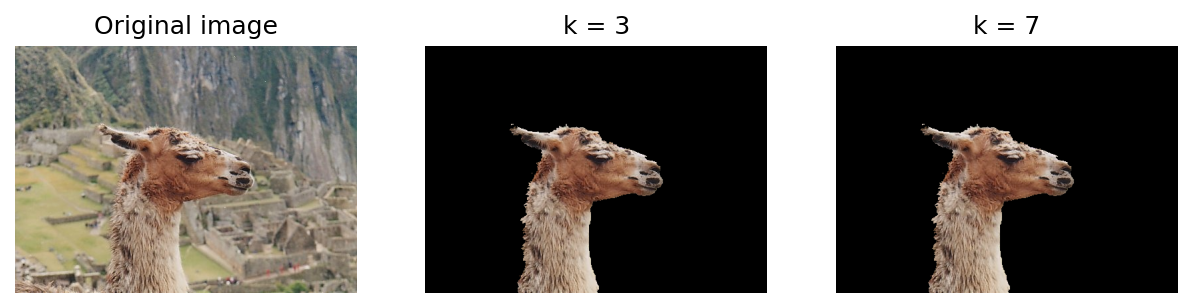

In [246]:
# Comparing the results
img = cv2.imread(filename)
mask1 = cv2.imread("./../study/gmmk/mask_k3.bmp", cv2.IMREAD_GRAYSCALE)
mask2 = cv2.imread("./../study/gmmk/mask_k7.bmp", cv2.IMREAD_GRAYSCALE)
# Visualize things
plt.figure(figsize=(10, 5.5), dpi=150)
plt.subplot(1,3,1)
plt.title("Original image")
plt.imshow(img[..., ::-1])
plt.axis('off')
plt.subplot(1,3,2)
plt.title("k = 3")
img_i1 = cv2.bitwise_and(img, img, mask=mask1)
plt.imshow(img_i1[..., ::-1])
plt.axis('off')
plt.subplot(1,3,3)
plt.title("k = 7")
img_i3 = cv2.bitwise_and(img, img, mask=mask2)
plt.imshow(img_i3[..., ::-1])
plt.axis('off')
plt.show()

In [248]:
# Let's compare scores
gt_mask = cv2.imread(filename.replace("images/", "ground_truth/")\
    .replace(".jpg", ".bmp"), cv2.IMREAD_GRAYSCALE)   # Original ground truth
print(f"Jaccard Similarity:\n"
    f"\tk = 3: {metric_jacc_sim(mask1, gt_mask)*100:.2f}%\t"
    f"\tk = 7: {metric_jacc_sim(mask2, gt_mask)*100:.2f}%"
)

Jaccard Similarity:
	k = 3: 93.37%		k = 7: 93.41%


We can see that a higher $k$ is not _significantly_ better, maybe using higher number of iterations combined with user input is better (speed and efficiency wise).

## Deliverable 3: Four or eight neighbor connectivity

As we connect more neighbors, our graph segmentation algorithm will take more time (graph becomes more densely connected). But this is beneficial and leads to faster convergence (as we're considering their weights in the graph optimization).

Let's consider a case of 4 neighbor vs. 8 neighbor for `flower`

In [249]:
# -------- 4-neighbor --------
filename = '../images/flower.jpg'
# Main program loop
try:
    rval = run(filename, nhood=FOUR_NEIGHBOR, verbose=True)
except Exception as exc:
    print(f"Exception: {exc}")
    traceback.print_exc()
finally:
    cv2.destroyAllWindows()

[1648922852.4336867] Started GrabCut
[1648922853.2006881] Iteration 0 of GrabCut
[1648922860.1486866] Starting st_mincut
[1648922862.426687] Finished st_mincut
[1648922862.5236857] Iteration 0 gives: 1680993.5394365478
[1648922862.5866895] Iteration 1 of GrabCut
[1648922869.7696877] Starting st_mincut
[1648922872.2166853] Finished st_mincut
[1648922872.303715] Iteration 1 gives: 1617575.3561339376
[1648922872.3077145] Iteration 2 of GrabCut
[1648922879.9796956] Starting st_mincut
[1648922882.503691] Finished st_mincut
[1648922882.5876877] Iteration 2 gives: 1617064.7288404987
[1648922882.5936868] GrabCut finished
Exit command received


In [250]:
# -------- 8-neighbor --------
filename = '../images/flower.jpg'
# Main program loop
try:
    rval = run(filename, nhood=EIGHT_NEIGHBOR, verbose=True)
except Exception as exc:
    print(f"Exception: {exc}")
    traceback.print_exc()
finally:
    cv2.destroyAllWindows()

Draw the rectangle first.
[1648922933.2904277] Started GrabCut
[1648922935.0544288] Iteration 0 of GrabCut
[1648922944.4124265] Starting st_mincut
[1648922946.4344263] Finished st_mincut
[1648922946.5584288] Iteration 0 gives: 1705352.1418863805
[1648922946.5844314] Iteration 1 of GrabCut
[1648922956.1774285] Starting st_mincut
[1648922958.4949534] Finished st_mincut
[1648922958.628978] Iteration 1 gives: 1641878.0015320804
[1648922958.6319556] Iteration 2 of GrabCut
[1648922968.216511] Starting st_mincut
[1648922970.3784814] Finished st_mincut
[1648922970.5415003] Iteration 2 gives: 1636811.3696993126
[1648922970.5504856] GrabCut finished
Exit command received


We can see that eight neighbor gives better results, but slightly takes more time. Let's see them side-by-side and measure accuracies.

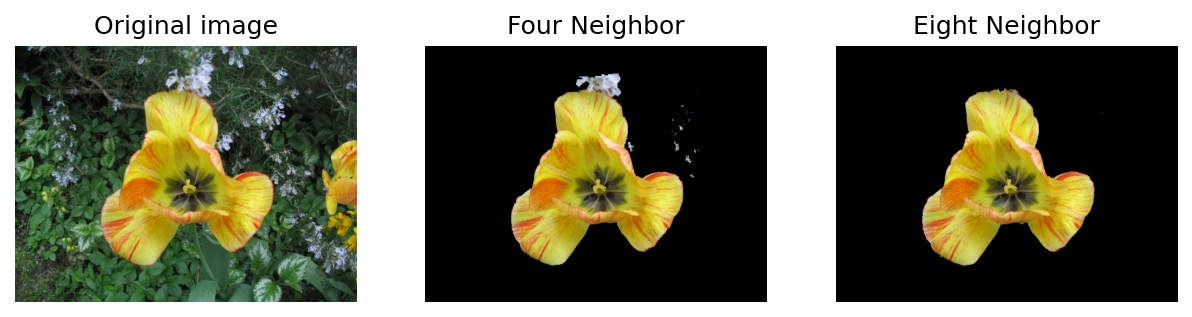

In [251]:
# Comparing the results
img = cv2.imread(filename)
mask1 = cv2.imread("./../study/nhood/mask_n4.bmp", cv2.IMREAD_GRAYSCALE)
mask2 = cv2.imread("./../study/nhood/mask_n8.bmp", cv2.IMREAD_GRAYSCALE)
# Visualize things
plt.figure(figsize=(10, 5.5), dpi=150)
plt.subplot(1,3,1)
plt.title("Original image")
plt.imshow(img[..., ::-1])
plt.axis('off')
plt.subplot(1,3,2)
plt.title("Four Neighbor")
img_i1 = cv2.bitwise_and(img, img, mask=mask1)
plt.imshow(img_i1[..., ::-1])
plt.axis('off')
plt.subplot(1,3,3)
plt.title("Eight Neighbor")
img_i3 = cv2.bitwise_and(img, img, mask=mask2)
plt.imshow(img_i3[..., ::-1])
plt.axis('off')
plt.show()

In [252]:
# Let's compare scores
gt_mask = cv2.imread(filename.replace("images/", "ground_truth/")\
    .replace(".jpg", ".bmp"), cv2.IMREAD_GRAYSCALE)   # Original ground truth
print(f"Jaccard Similarity:\n"
    f"\tFour Neighbor: {metric_jacc_sim(mask1, gt_mask)*100:.2f}%\t"
    f"\tEight Neighbor: {metric_jacc_sim(mask2, gt_mask)*100:.2f}%"
)

Jaccard Similarity:
	Four Neighbor: 94.13%		Eight Neighbor: 98.21%


We can see that eight neighbor is better, but takes 37 seconds as compared to 30 seconds of four neighbor.

## Deliverable 4: Choice of gamma

A higher gamma should put more weight on the difference between pixel values (euclidean distance in RGB space). For a high gamma, there will be more weightage to the pixel color distances (as opposed to the GMM model).


## Deliverable 5: Better ways of using bounding box

It is possible to have a tight object detector. We see that even the `moon` has better accuracy if the bounding box is tight.

It will be even better if we can have lasso selection, where we select the closed contours which perfectly fit regions. This will theoretically give a very good model of border (and therefore `fg` and `bg`).


Let's see the effect of bounding box on `moon`

In [259]:
# -------- 1 iterations: Bounding box only (run twice) --------
filename = '../images/fullmoon.jpg'
# Main program loop
try:
    rval = run(filename, num_iter=1, verbose=True)
except Exception as exc:
    print(f"Exception: {exc}")
    traceback.print_exc()
finally:
    cv2.destroyAllWindows()

[1648923877.6128042] Started GrabCut
[1648923878.540802] Iteration 0 of GrabCut
[1648923882.9548023] Starting st_mincut
[1648923883.2598016] Finished st_mincut
[1648923883.3158028] Iteration 0 gives: 128942.12460643105
[1648923883.3428032] GrabCut finished
Exit command received


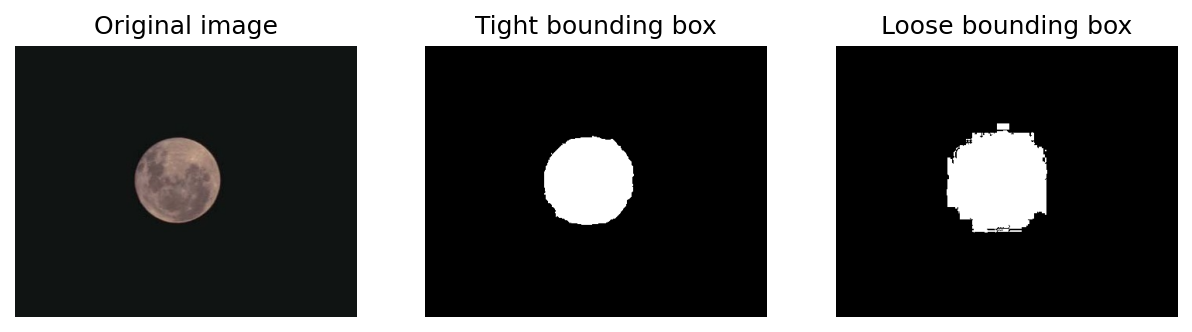

In [257]:
# Comparing the results
img = cv2.imread(filename)
mask1 = cv2.imread("./../study/bb/mask_tight.bmp", cv2.IMREAD_GRAYSCALE)
mask2 = cv2.imread("./../study/bb/mask_loose.bmp", cv2.IMREAD_GRAYSCALE)
# Visualize things
plt.figure(figsize=(10, 5.5), dpi=150)
plt.subplot(1,3,1)
plt.title("Original image")
plt.imshow(img[..., ::-1])
plt.axis('off')
plt.subplot(1,3,2)
plt.title("Tight bounding box")
plt.imshow(mask1, 'gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.title("Loose bounding box")
plt.imshow(mask2, 'gray')
plt.axis('off')
plt.show()

In [258]:
# Let's compare scores
gt_mask = cv2.imread(filename.replace("images/", "ground_truth/")\
    .replace(".jpg", ".bmp"), cv2.IMREAD_GRAYSCALE)   # Original ground truth
print(f"Jaccard Similarity:\n"
    f"\tTight: {metric_jacc_sim(mask1, gt_mask)*100:.2f}%\t"
    f"\tLoose: {metric_jacc_sim(mask2, gt_mask)*100:.2f}%"
)

Jaccard Similarity:
	Tight: 87.60%		Loose: 66.37%


Tight is significantly better than loose fit